# Introduction

In this notebook I will do some exploratory simulations to see the effects of stressors on microbial communities. 

In [66]:
using Pkg
Pkg.activate("..")

using Distributions, LinearAlgebra, MiCRM, EasyFit, Distances, StatsBase
using OrdinaryDiffEq
using CairoMakie, Colors, ColorSchemes

  Activating project at `~/Projects/Working/ErCite/chemicalstressors`


here we simulate a single community with a stressor

  0.604870 seconds (981 allocations: 711.641 KiB)


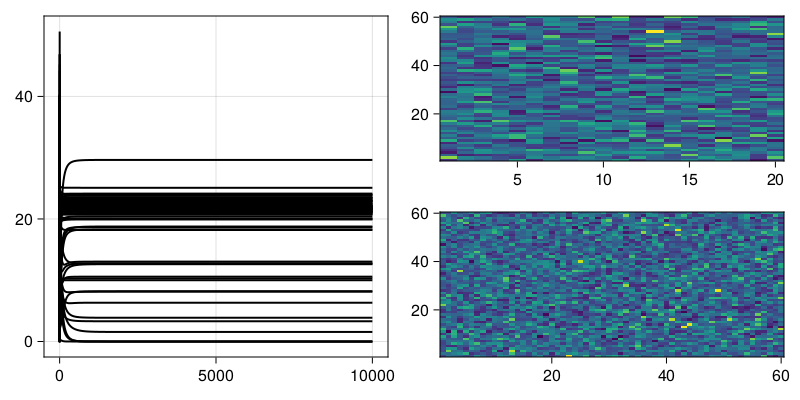

In [544]:
#params
N,M = 20,60

fu(N,M,kw) = MiCRM.Parameters.modular_uptake(N,M, N_clusters = 1)
fl(N,M,kw)  = MiCRM.Parameters.modular_leakage(M, N_clusters = 1)
p = MiCRM.Parameters.generate_params(N, M, f_u = fu, f_l = fl, λ = 0.3, S_ind = N + M + 1, d = 0.0, γ = ones(N))


#derivative function
g(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t, growth! = MiCRM.Stressors.growth_MiCRM_stressor!, extrinsic! = MiCRM.Stressors.stressor!)
#simualtion params
x0 = rand(N+M+1)
x0[p.kw.S_ind] = 10
t = (0.0,10000.0)

prob = ODEProblem(g,x0,t,p)
sol = solve(prob, AutoTsit5(Rosenbrock23()))
@time sol = solve(prob, AutoTsit5(Rosenbrock23()));

plot_sol(sol,ax) = Makie.series!(ax, sol.t, sol[:,:], solid_color = "black")

f = Figure(resolution = (800,400))
plot_sol(sol, Axis(f[1,1]))

heatmap!(Axis(f[1,2][1,1]), sol.prob.p.u)
heatmap!(Axis(f[1,2][2,1]), sol.prob.p.l)

f

In [265]:
# revise()
function remove_extinct(sol)
    p = sol.prob.p
    
    to_keep = findall(sol[end][1:p.N]  .> eps())
    to_rm = findall(sol[end][1:p.N]  .< eps())
    
    p_dict = Dict(zip(keys(p),values(p)))

    #remove from params
    p_dict[:u] = p_dict[:u][to_keep,:]
    p_dict[:m] = p_dict[:m][to_keep]
    p_dict[:N] = length(to_keep)

    #stressor keywords
    kw_dict = Dict(zip(keys(p_dict[:kw]), values(p_dict[:kw])))
    kw_dict[:γ] = kw_dict[:γ][to_keep]
    kw_dict[:S_ind] = p_dict[:N] + p_dict[:M] + 1

    p_dict[:kw] = NamedTuple(kw_dict)

    p_new = NamedTuple(p_dict)
    
    u0 = deepcopy(sol(sol.t[end]))
    deleteat!(u0, to_rm)
        
    #simulate
    return(sol.prob.f, u0, (0.0,1e6), p_new)
end

remove_extinct (generic function with 1 method)

# Varying leakage

In [4]:
# #Varying leakage
# N_leak = 20
# N_rep = 10

# N,M = 10,10

# l_vec = range(0.0,0.8,length = N_leak)
# res = Array{Any,3}(undef,N_leak,N_rep,2)

# for i = 1:N_leak
#     for j = 1:N_rep
#         #generate params
#         p = MiCRM.Parameters.generate_params(N,M,λ = l_vec[i], S_ind = N+M+1, d = 0.0, γ = rand(N))
#         #inital simulation
#         x0 = rand(N+M+1)
#         x0[p.kw.S_ind] = 0.0
#         t = (0.0,1e6)
#         prob = ODEProblem(g,x0,t,p)
#         res[i,j,1] =  solve(prob, AutoTsit5(Rosenbrock23()))

#         #remove extinct
#         prob_ext = MiCRM.Stressors.remove_extinct(res[i,j,1])
#         prob_ext.u0[prob_ext.p.kw.S_ind] = 0.1
        
#         res[i,j,2] = solve(prob_ext, AutoTsit5(Rosenbrock23()))
#     end
# end

In [5]:
# f = Figure()
# ax1 = Axis(f[1,1])
# series!(ax1, res[10,7,1][:,:], solid_color = "black")

# ax2 = Axis(f[1,2])
# series!(ax2, res[10,7,2][:,:], solid_color = "black")

# linkyaxes!(ax1,ax2)

# f

In [6]:
# function check_equi(sol)
#     @assert sol(sol.t[end], Val{1}) |> x -> abs.(x) |> maximum < 1e-6
# end

# map(check_equi, res);

In [7]:
# function δN(sol1, sol2)
#     N1 = sum(sol1[end] .> eps()) - sol1.prob.p.M - 1
#     N2 = sum(sol2[end] .> eps()) - sol2.prob.p.M - 1
#     return(N2 - N1)
# end

# N_change = [δN(res[i,j,1],res[i,j,2]) for i = 1:N_leak, j = 1:N_rep]

# function δC(sol1, sol2)
#     C1 = sum(sol1[end][1:sol1.prob.p.N]) 
#     C2 = sum(sol2[end][1:sol2.prob.p.N])
#     return(C2 - C1)
# end

# C_change = [δC(res[i,j,1],res[i,j,2]) for i = 1:N_leak, j = 1:N_rep]


# function δR(sol1, sol2)
#     R1 = sum(sol1[end][sol1.prob.p.N + 1 : end-1]) 
#     R2 = sum(sol2[end][sol2.prob.p.N + 1 : end-1])
#     return(R2 - R1)
# end

# R_change = [δR(res[i,j,1],res[i,j,2]) for i = 1:N_leak, j = 1:N_rep]


# f = Figure(resolution = (800,200))
# ax = [Axis(f[1,1], ylabel = "ΔN"), Axis(f[1,2], ylabel = "ΔC", xlabel = "Leakage"), Axis(f[1,3], ylabel = "ΔR")]

# [scatter!(ax[1], l_vec, N_change[:,i], color = ("black",0.2)) for i = 1:N_rep ]
# hlines!(ax[1], [0.0], color = "red", linestyle = :dash)


# [scatter!(ax[2], l_vec, C_change[:,i], color = ("black",0.2)) for i = 1:N_rep ]
# hlines!(ax[2], [0.0], color = "red", linestyle = :dash)

# [scatter!(ax[3], l_vec, R_change[:,i], color = ("black",0.2)) for i = 1:N_rep ]
# hlines!(ax[3], [0.0], color = "red", linestyle = :dash)

# f

In [8]:
# #pred
# function pred(λ)
#     0.1 * 5.0 / (N * 0.1 * (1 - λ)) 
# end

# predicted_ΔR = pred.(l_vec)

# f = Figure(resolution = (800,400))
# ax = Axis(f[1,1], ylabel = "ΔR", xlabel = "leakage")

# [scatter!(ax, l_vec, R_change[:,i], color = ("black",0.2), label = "Simulated") for i = 1:N_rep ]
# lines!(ax, l_vec, predicted_ΔR, label = "Predicted")
# axislegend(ax, merge = true, position = :lt)

In [9]:
# function get_R_tot(sol)
#     sum(sol[end][sol.prob.p.N+1 : end-1])
# end

# function get_λ(sol)
#     sol.prob.p.kw.λ
# end


# top = (10 - 0.1) * 5
# bot = (get_R_tot.(res) .* (1 .- get_λ.(res)) * 0.01) * 100
    
# pred_ΔC = top ./ bot
# pred_ΔC = -mean(pred_ΔC, dims = [2,3])[:]

# ax = Axis(f[1,2],ylabel = "ΔC", xlabel = "leakage")

# [scatter!(ax, l_vec, C_change[:,i], color = ("black",0.2), label = "Simulated") for i = 1:N_rep ]
# lines!(ax, l_vec, pred_ΔC, label = "Predicted")
# axislegend(ax, merge = true, position = :lt)

# f

# modular uptake


In [601]:
#Varying leakage
N_leak = 5
N_mod = 5
N_rep = 5
N_S = 5

N,M = 25, 25

l_vec = range(0.0,0.8,length = N_leak)
mod_vec = range(1.0, 10.0, length = N_mod)
S_vec = 10 .^ range(-3,1, length = N_S)

res = Array{Any,6}(undef, N_leak, N_mod, N_mod, N_S, N_rep, 2)

for i = 1:N_leak
    for j = 1:N_mod
        for k = 1:N_mod
            for l = 1:N_S
                #define uptake function
                fu(N,M,kw) = MiCRM.Parameters.modular_uptake(N,M, N_clusters = N, s_ratio = mod_vec[j])
                fl(N,M,kw) = MiCRM.Parameters.modular_leakage(M, N_clusters = N, s_ratio = mod_vec[k])

                for r = 1:N_rep
                    p = MiCRM.Parameters.generate_params(N, M, f_u = fu , λ = l_vec[i], S_ind = N + M + 1, d = 0.0, γ = rand(N))

                    #inital simulation
                    x0 = rand(N+M+1)
                    x0[p.kw.S_ind] = 0.0
                    t = (0.0,1e6)

                    prob = ODEProblem(g,x0,t,p)
                    res[i,j,k,l,r,1] =  solve(prob, AutoTsit5(Rosenbrock23()))

                    #remove extinct
                    prob_ext = ODEProblem(g, remove_extinct(res[i,j,k,l,r,1])[2:end]...)
                    prob_ext.u0[prob_ext.p.kw.S_ind] = S_vec[l]

                    res[i,j,k,l,r,2] = solve(prob_ext, AutoTsit5(Rosenbrock23()))
                end
            end
        end
    end
end

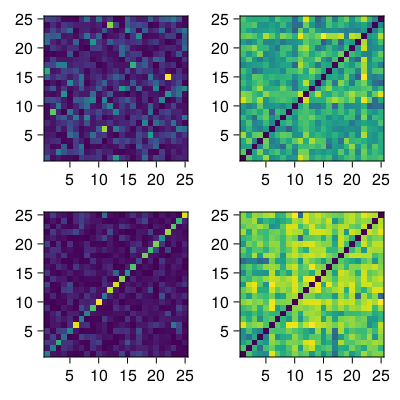

In [609]:
u1 = res[1,1,1,1,1,1].prob.p.u
u2 = res[1,end,end,end,1,1].prob.p.u

d1 = pairwise(cosine_dist, u1,u1, dims=1)
d2 = pairwise(cosine_dist, u2,u2, dims=1)

f = Figure(resolution = (400,400))
ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])
ax3 = Axis(f[2,1])
ax4 = Axis(f[2,2])

heatmap!(ax1, u1)
heatmap!(ax2, d1)

heatmap!(ax3, u2)
heatmap!(ax4, d2)

f

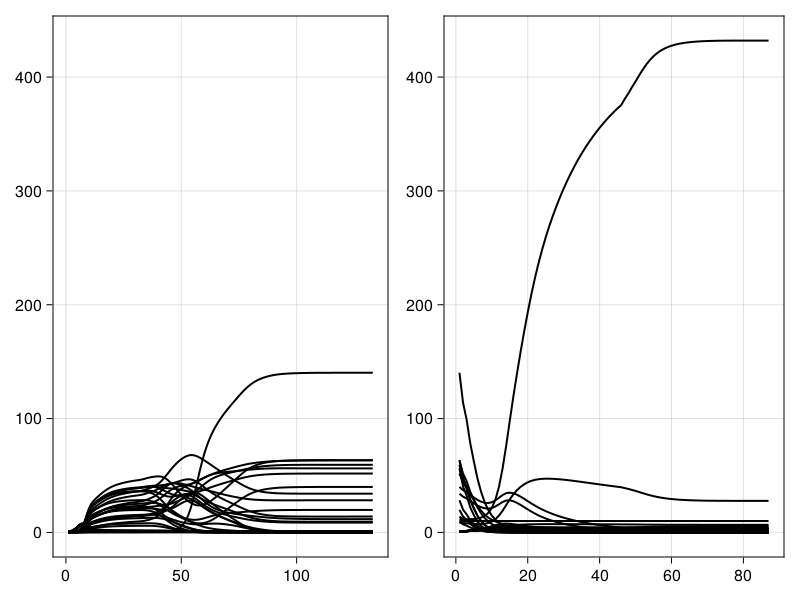

In [610]:
f = Figure()
ax1 = Axis(f[1,1])
series!(ax1, res[1,1,1,end,1,1][:,:], solid_color = "black")

ax2 = Axis(f[1,2])
series!(ax2, res[1,1,1,end,1,2][:,:], solid_color = "black")

linkyaxes!(ax1,ax2)

f

# interactions

In [611]:
function mean_offdiag(A)
    A_tot = sum(A) - sum(diag(A))
    return(A_tot / (dim(A) * (dim(A) - 1)))
    
end

#calculate overalap
function avg_comp_overlap(sol)
    X = sol.prob.p.u
    R = 1 .- pairwise(cosine_dist, X, X, dims=1)
    
    return(mean_offdiag(R))
end

#calculate overalap
function avg_coop_overlap(sol)
    X = sol.prob.p.u
    Y = sol.prob.p.u * sol.prob.p.l
    R = 1 .- pairwise(cosine_dist, X, Y, dims=1)
    
    return(mean_offdiag(R))
end

avg_coop_overlap (generic function with 1 method)

# System responses

In [612]:
# System responses
function δN(sol1, sol2)
    N1 = sum(sol1[end] .> eps()) - sol1.prob.p.M - 1
    N2 = sum(sol2[end] .> eps()) - sol2.prob.p.M - 1
    return(N2 - N1)
end

function δC(sol1, sol2)
    C1 = sum(sol1[end][1:sol1.prob.p.N]) 
    C2 = sum(sol2[end][1:sol2.prob.p.N])
    return(C2 - C1)
end

function δR(sol1, sol2)
    R1 = sum(sol1[end][sol1.prob.p.N + 1 : end-1]) 
    R2 = sum(sol2[end][sol2.prob.p.N + 1 : end-1])
    return(R2 - R1)
end

δR (generic function with 1 method)

In [613]:
#analysis
#define functions to calculate sensitvtiy
"""
    dRdS(p,C_extant)

Calculates a vector of resource sensitvties given a parameter set and the extant consumers
"""
function dRdS(p,C_extant)   
    return(pinv(p.u[C_extant,:] * diagm((ones(p.M) - p.l * ones(p.M)))) * p.kw.γ[C_extant])
end

"""
    dCdS(p, C_extant, R, C, dR)

    Calculates consumer sensitvtiy given parameters as well as the system equilibirum state. 
"""
function dCdS(p, C_extant, R, C, dR)
   leakage_factor = (p.l' - I(p.M))
       
    a = pinv(leakage_factor * diagm(R) * p.u[C_extant,:]')
    b = diagm(dR) * p.ω - leakage_factor * diagm(dR) * p.u[C_extant,:]' * C[C_extant]

    return(a * b)
end

"""
    calc_sensitvtiy(sol)

Calculates the sensitvtiy of the whole system. Takes a single solution object for a simulation that has already reached equilibirum. 
"""
function calc_sensitvtiy(sol; t = :both)
    #get final deriv + assert equilibrium
    # print(minimum( sol(sol.t[end],Val{1})) )
    
    #get end masses
    C,R = sol[end][1:sol.prob.p.N], sol[end][sol.prob.p.N + 1  : end - 1]
    
    C_extant = findall(C .> eps())
    
    dR = dRdS(sol.prob.p, C_extant)
    dC = dCdS(sol.prob.p, C_extant, R, C, dR)
    
    if t == :C
        return(dC)
    elseif t == :R
        return(dR)
    else
        return(vcat(dC[:],dR[:]))
    end
end

calc_sensitvtiy

In [614]:
#predicted
dS_C = sum.(calc_sensitvtiy.(res, t = :C))
dS_R = sum.(calc_sensitvtiy.(res, t = :R))

#Apply metrics
comp = map(avg_comp_overlap, res[:,:,:,:,:,2])
coop = map(avg_coop_overlap, res[:,:,:,:,:,2])

ΔN = [δN(res[i,j,k,l,r,1],res[i,j,k,l,r,2]) for i = 1:N_leak, j = 1:N_mod, k = 1:N_mod, l = 1:N_S, r = 1:N_rep]
ΔC = [δC(res[i,j,k,l,r,1],res[i,j,k,l,r,2]) for i = 1:N_leak, j = 1:N_mod, k = 1:N_mod, l = 1:N_S, r = 1:N_rep]
ΔR = [δR(res[i,j,k,l,r,1],res[i,j,k,l,r,2]) for i = 1:N_leak, j = 1:N_mod, k = 1:N_mod, l = 1:N_S, r = 1:N_rep];

#gamma tot
f_γ(x) = sum(x.prob.p.kw.γ)
γ_tot = map(f_γ, res[:,:,:,:,:,1])

#λ
λ_tot = map(x -> x.prob.p.kw.λ, res[:,:,:,:,:,1]);


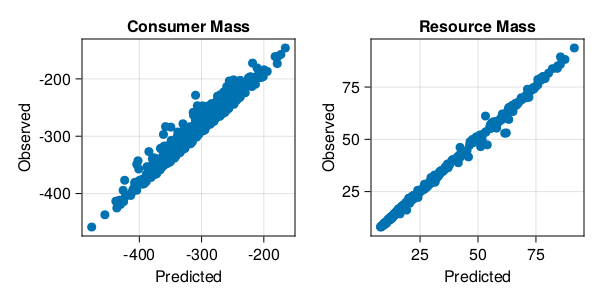

In [615]:
f = Figure(resolution = (600,300))
ax1 = Axis(f[1,1],title = "Consumer Mass", xlabel = "Predicted", ylabel = "Observed")
ax2 = Axis(f[1,2],title = "Resource Mass", xlabel = "Predicted", ylabel = "Observed")
scatter!(ax1, dS_C[:,:,:,2,:,1][:], ΔC[:,:,:,2,:][:]./S_vec[2])
scatter!(ax2, dS_R[:,:,:,2,:,1][:], ΔR[:,:,:,2,:][:]./S_vec[2])
f

First we look at the correspondance of the predicted and observed change in consumer and resource mass. We can see that they align well showing the analytical results are a good predictor. 

# Leakage
First we look at the direct effects of leakage on the system

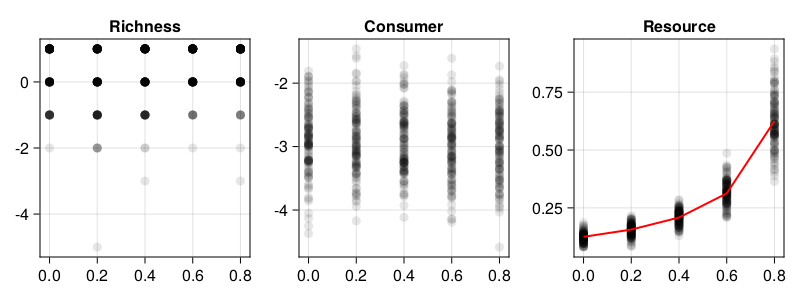

In [621]:
f = Figure(resolution = (800,300))
c = ("black", 0.1)
#richness
ax1 = Axis(f[1,1], title = "Richness")
[scatter!(ax1, l_vec, ΔN[:,j,k,l,r], color = c) for j = 1:N_mod, k = 1:N_mod, l = 2, r = 1:N_rep]
#C
ax1 = Axis(f[1,2],title = "Consumer")
[scatter!(ax1, l_vec, ΔC[:,j,k,l,r], color = c) for j = 1:N_mod, k = 1:N_mod, l = 2, r = 1:N_rep]
#R
ax1 = Axis(f[1,3], title = "Resource")
pred = S_vec[2] * 12.5 ./ (N * mean(p.u) .* (1 .- l_vec))


[scatter!(ax1, l_vec, ΔR[:,j,k,l,r], color = c) for j = 1:N_mod, k = 1:N_mod, l = 2, r = 1:N_rep]
lines!(ax1, l_vec, pred, color = "red", linewidth = 2)
f

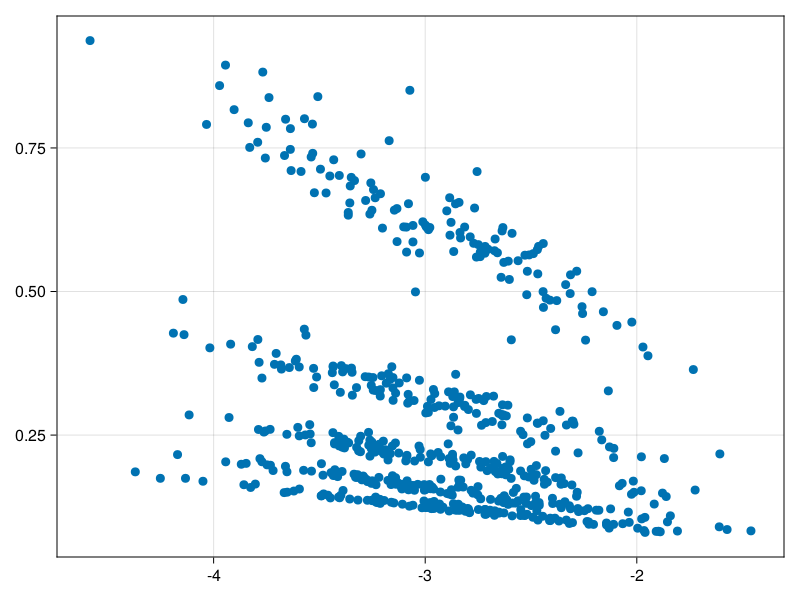

In [624]:
scatter(ΔC[:,:,:,2,:][:], ΔR[:,:,:,2,:][:])

In [646]:
C = res[1][end][1:N]
γ = res[1].prob.p.kw.γ

N * mean(C .* γ)



175.83580149579203

In [648]:
N * mean(C) * mean(γ) 

266.68325443564714

looking at leakage we can see that the largest effect is on resources. The prelationship can actually be predicted approximately taking the form $\Delta_R = \frac{1}{1 - \lambda}$

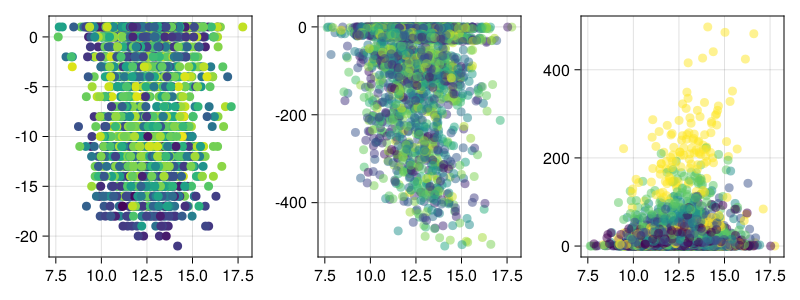

In [618]:

#color by leakage
cs = ColorScheme([colorant"red", colorant"blue"])
linear_map(x,min,max) = (x-min) / max

f = Figure(resolution = (800,300))
c = ("black", 0.1)
#richness
ax1 = Axis(f[1,1])
scatter!(ax1, γ_tot[:], ΔN[:], color = coop, colormap = (:viridis, 1.0))
#C
ax1 = Axis(f[1,2])
scatter!(ax1, γ_tot[:], ΔC[:], color = comp, transparency = true, colormap = (:viridis, 0.5))
#R
ax1 = Axis(f[1,3])
scatter!(ax1, γ_tot[:], ΔR[:], color = λ_tot,colormap = (:viridis, 0.5))

f

# Interactions

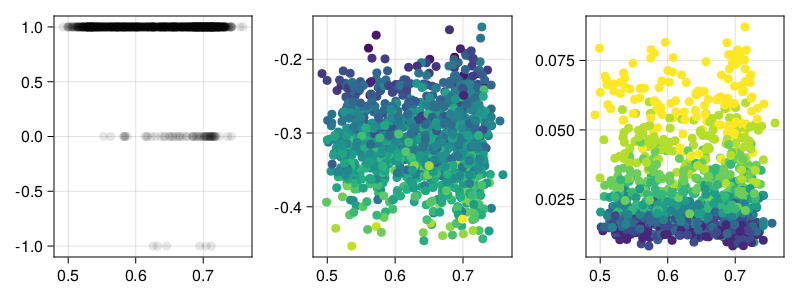

In [573]:
f = Figure(resolution = (800,300))
c = ("black", 0.1)
#richness
ax1 = Axis(f[1,1])
scatter!(ax1, coop[:], ΔN[:], color = c)
#C
ax1 = Axis(f[1,2])
scatter!(ax1, coop[:], ΔC[:], color = γ_tot)
#R
ax1 = Axis(f[1,3])
scatter!(ax1, coop[:], ΔR[:], color = λ_tot)

f

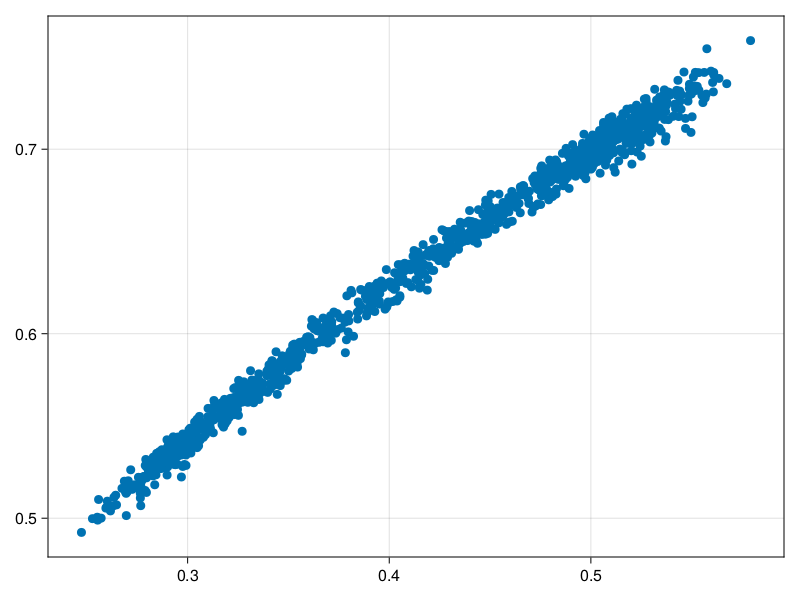

In [574]:
scatter(comp[:], coop[:])

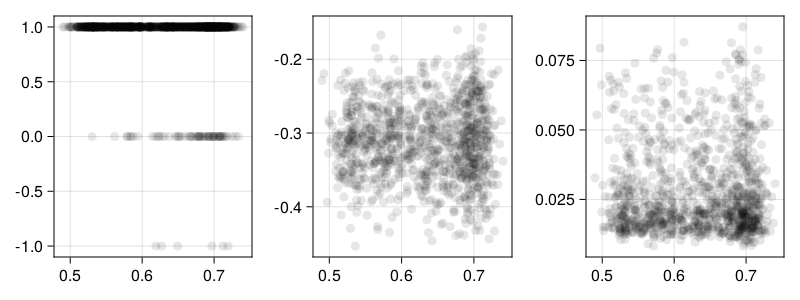

In [361]:
f = Figure(resolution = (800,300))
c = ("black", 0.1)
#richness
ax1 = Axis(f[1,1])
scatter!(ax1, coop[:], ΔN[:], color = c)
#C
ax1 = Axis(f[1,2])
scatter!(ax1, coop[:], ΔC[:], color = c)
#R
ax1 = Axis(f[1,3])
scatter!(ax1, coop[:], ΔR[:], color = c)

f

## cov(comp_overlap[:,:,:,1][:],C_change[:])